# 1. Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn

from tqdm import tqdm_notebook

%load_ext google.cloud.bigquery

In [2]:
%%bigquery df

WITH clean AS 
(
SELECT 
  DISTINCT full_visitor_id , client_id , organization_uuid , country_id , session_id , session_start_time , session_end_time ,
  session_reached_minimal_created , 
  traffic_source_level_3 , traffic_source_source, traffic_source_medium,
  COUNT(DISTINCT organization_uuid) OVER(PARTITION BY full_visitor_id ) as nr_unique_uuid
FROM `izettle-dp-pipeline-prod.legacy_views.google_analytics_session` 
WHERE full_visitor_id NOT IN (--list of visitor id that has no client id and only one unique (NA) uuid and 
                          SELECT
                              full_visitor_id 
                          FROM (
                                SELECT
                                    DISTINCT full_visitor_id , client_id , organization_uuid  ,
                                    DENSE_RANK() OVER(PARTITION BY full_visitor_id ORDER BY client_id DESC, organization_uuid DESC) as rank_entry 
                                    #optimize the code by group by and array_agg()?
                                FROM `izettle-dp-pipeline-prod.legacy_views.google_analytics_session` 
                                WHERE full_visitor_id IN (SELECT 
                                                            DISTINCT full_visitor_id
                                                          FROM `izettle-dp-pipeline-prod.legacy_views.google_analytics_session` 
                                                          WHERE client_id IS NULL AND organization_uuid IS NULL
                                                          )
                                #ORDER BY full_visitor_id , rank_entry
                                      )
                          WHERE rank_entry = 1
                          AND client_id IS NULL
                          AND organization_uuid IS NULL
                          ) 
), 
ga_processed AS (
--delete row with no uuid and nr_unique_uuid per group of visitor id of that row > 1 
-- and fill NA uuid cells (Expected: rows with NA uuid and nr_unique_uuid =0 left)--
SELECT 
  full_visitor_id , client_id , organization_uuid , 
  IFNULL(organization_uuid, MAX(organization_uuid) OVER(PARTITION BY full_visitor_id)) as fill_uuid ,
  country_id , session_id , session_start_time , session_end_time ,
  session_reached_minimal_created ,
  traffic_source_level_3 , traffic_source_source, traffic_source_medium,
  nr_unique_uuid
FROM clean
WHERE 
  organization_uuid IS NOT NULL
  OR
  (organization_uuid IS NULL AND nr_unique_uuid <= 1)
),
merged_campaign AS(
SELECT
  full_visitor_id , 
  IFNULL(fill_uuid, MAX(campaign_data.organization_uuid) OVER(PARTITION BY client_id)) as fill_uuid_2,
  country_id , session_id , session_start_time , session_end_time ,
  session_reached_minimal_created ,
  traffic_source_level_3, traffic_source_source, traffic_source_medium
FROM ga_processed
LEFT JOIN (SELECT
              DISTINCT google_analytics_id , organization_uuid 
           FROM `izettle-dp-pipeline-prod.legacy_views.user_campaign_data`
           WHERE google_analytics_id IN (
                                         SELECT DISTINCT google_analytics_id
                                         FROM `izettle-dp-pipeline-prod.legacy_views.user_campaign_data`
                                         GROUP BY google_analytics_id 
                                         HAVING COUNT(DISTINCT organization_uuid) = 1
                                         ) 
          ) AS campaign_data
ON ga_processed.client_id = campaign_data.google_analytics_id 
),
merged_oc AS (
--customer journey of merchants until registration tracked by ga cookies--
--only ~ 245,000 merchants have the recorded journey. The rest that we have only the last touch point can be found in the customer_acquisition table--
SELECT
  ft.fill_uuid_2 as organization_uuid , oc.organization_created ,
  ft.full_visitor_id, ft.country_id , ft.session_id , ft.session_start_time , ft.session_end_time ,
  ft.session_reached_minimal_created ,
  ft.traffic_source_level_3,
  traffic_source_source, traffic_source_medium
FROM merged_campaign ft
LEFT JOIN `izettle-dp-pipeline-prod.legacy_views.organization_customer` oc
ON ft.fill_uuid_2 =oc.organization_uuid 
WHERE fill_uuid_2 IS NOT NULL
AND oc.organization_created >= ft.session_start_time 
)
SELECT
  uuid_left.organization_uuid ,
  uuid_left.organization_created ,
  #uuid_left.traffic_source_level_3 as traffic_source_level_3_af ,
  #merged_oc.full_visitor_id, 
  uuid_left.country_id , 
  #merged_oc.session_id , merged_oc.session_start_time , merged_oc.session_end_time ,
  merged_oc.session_reached_minimal_created ,
  #merged_oc.traffic_source_level_3,
  #merged_oc.traffic_source_source, merged_oc.traffic_source_medium,
  IFNULL(merged_oc.traffic_source_level_3, uuid_left.traffic_source_level_3) as traffic_source_full
FROM (
      SELECT 
        af.organization_uuid,
        af.traffic_source_level_3 , oc.organization_created , oc.country_id
      FROM `izettle-dp-pipeline-prod.legacy_views.attribution_funnel_traffic_source` af
      JOIN `izettle-dp-pipeline-prod.legacy_views.organization_customer` oc
      ON af.organization_uuid = oc.organization_uuid 
      AND oc.organization_created >= '2017-09-01'
      ) as uuid_left
LEFT JOIN merged_oc
ON uuid_left.organization_uuid = merged_oc.organization_uuid 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1735350 entries, 0 to 1735349
Data columns (total 5 columns):
organization_uuid                  object
organization_created               datetime64[ns, UTC]
country_id                         object
session_reached_minimal_created    object
traffic_source_full                object
dtypes: datetime64[ns, UTC](1), object(4)
memory usage: 66.2+ MB


In [4]:
%%bigquery df_af
SELECT 
  af.organization_uuid,
  oc.organization_created,
  oc.country_id,
  af.traffic_source_level_3 as traffic_source_full
FROM `izettle-dp-pipeline-prod.legacy_views.attribution_funnel_traffic_source` af
JOIN `izettle-dp-pipeline-prod.legacy_views.organization_customer` oc
ON oc.organization_uuid = af.organization_uuid
WHERE oc.organization_created >= '2017-09-01'            

In [5]:
df_af.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1135957 entries, 0 to 1135956
Data columns (total 4 columns):
organization_uuid       1135957 non-null object
organization_created    1135957 non-null datetime64[ns, UTC]
country_id              1135957 non-null object
traffic_source_full     1135957 non-null object
dtypes: datetime64[ns, UTC](1), object(3)
memory usage: 34.7+ MB


In [18]:
%%bigquery df_kyc_accepted
SELECT 
  organization_uuid 
FROM `izettle-dp-pipeline-prod.legacy_views.organization_customer` 
WHERE organization_created >= '2017-09-01'
AND first_non_minimal_signup_status_assigned IS NOT NULL

In [19]:
df_kyc_accepted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 652289 entries, 0 to 652288
Data columns (total 1 columns):
organization_uuid    652289 non-null object
dtypes: object(1)
memory usage: 5.0+ MB


# 2. Data Preparation

Some uuid (from GA tracking) cannt be traced the last touch point in GA. Pulling these last touch point from attribution_funnel

In [7]:
df_concat_1 = df[df['session_reached_minimal_created'].isna()]
df_concat_2 = df[df['session_reached_minimal_created'] == True] #duplicate here
df_concat_2 = df_concat_2.drop_duplicates('organization_uuid')

In [8]:
last_touch_ls = list(df_concat_2['organization_uuid'].unique()) + list(df_concat_1['organization_uuid'].unique())
df_concat_3 = df_af[~df_af['organization_uuid'].isin(last_touch_ls)]

In [9]:
df_concat_1 = df_concat_1.drop('session_reached_minimal_created', axis=1)
df_concat_2= df_concat_2.drop('session_reached_minimal_created', axis=1)

In [10]:
print(df_concat_1.info())
print(df_concat_2.info())
print(df_concat_3.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 432307 entries, 4 to 1735349
Data columns (total 4 columns):
organization_uuid       432307 non-null object
organization_created    432307 non-null datetime64[ns, UTC]
country_id              432307 non-null object
traffic_source_full     432307 non-null object
dtypes: datetime64[ns, UTC](1), object(3)
memory usage: 16.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 663594 entries, 3 to 1735348
Data columns (total 4 columns):
organization_uuid       663594 non-null object
organization_created    663594 non-null datetime64[ns, UTC]
country_id              663594 non-null object
traffic_source_full     663594 non-null object
dtypes: datetime64[ns, UTC](1), object(3)
memory usage: 25.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 40056 entries, 9 to 1135856
Data columns (total 4 columns):
organization_uuid       40056 non-null object
organization_created    40056 non-null datetime64[ns, UTC]
country_id           

In [20]:
df_full = pd.concat([df_concat_1, df_concat_2, df_concat_3], axis = 0, ignore_index=True)

In [21]:
list(df_full.traffic_source_full.unique())

['ds_inbound_inbound',
 'ds_keyaccount_keyaccount',
 'ps_other_partner',
 'o_paid_sem',
 'ps_bank_bank',
 'o_organic_app',
 'o_organic_seo',
 'o_paid_social',
 'o_organic_null',
 'o_organic_direct',
 'o_organic_invite',
 'o_paid_affiliate',
 'o_organic_referral',
 'o_paid_app_install',
 'ps_other_isc',
 'pp_paypal_paypal',
 'ps_product_api',
 'ps_other_local_partnership',
 'ps_pay_sdk',
 'ds_keyaccount_sdk']

In [22]:
dict_channels = {'ps_pay_sdk':'partnerships', 'ps_product_api':'partnerships', 'ps_bank_bank':'partnerships',
                'ps_other_local_partnership':'partnerships', 'ps_other_partner':'partnerships',
                 'ps_other_isc':'partnerships', 'pp_paypal_paypal':'partnerships',
                'ds_inbound_inbound':'direct','ds_keyaccount_sdk':'direct','ds_keyaccount_keyaccount':'direct'}

def map_value(df):
    df['traffic_source'] = ''
    for i in range(0, df.shape[0]):
        if df.traffic_source_full.iloc[i] in list(dict_channels.keys()):
            df['traffic_source'].iat[i] = dict_channels[df.traffic_source_full.iloc[i]]
        else: df['traffic_source'].iat[i] = df['traffic_source_full'].iat[i]

map_value(df_full)

In [24]:
basetable = df_full[df_full['organization_uuid'].isin(df_kyc_accepted['organization_uuid'])]
basetable.reset_index(inplace=True)

In [27]:
basetable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 652289 entries, 0 to 652288
Data columns (total 6 columns):
index                   652289 non-null int64
organization_uuid       652289 non-null object
organization_created    652289 non-null datetime64[ns, UTC]
country_id              652289 non-null object
traffic_source_full     652289 non-null object
traffic_source          652289 non-null object
dtypes: datetime64[ns, UTC](1), int64(1), object(4)
memory usage: 29.9+ MB


# 3. Last touch model

## 3.1 Global

In [17]:
def last_touch(df):
    df_model = pd.DataFrame(df.traffic_source.value_counts())
    df_model.columns = ['conversion_abs']
    df_model['conversion_rate'] = df_model['conversion_abs']/df_model['conversion_abs'].sum()
    
    
    fig = plt.figure(figsize = (10,8))

    fig.add_subplot(2,1,1)
    plt.barh(y = df_model.index, width = 'conversion_rate', data = df_model, color = sbn.color_palette('tab20'))
    plt.title('Last touch attribution model')
    plt.xlabel('conversion rate')

    fig.add_subplot(2,1,2)
    plt.barh(y = df_model.index, width = 'conversion_abs', data = df_model, color = 'slateblue')
    plt.xlabel('abs number of conversion')

    plt.show()
    return df_model

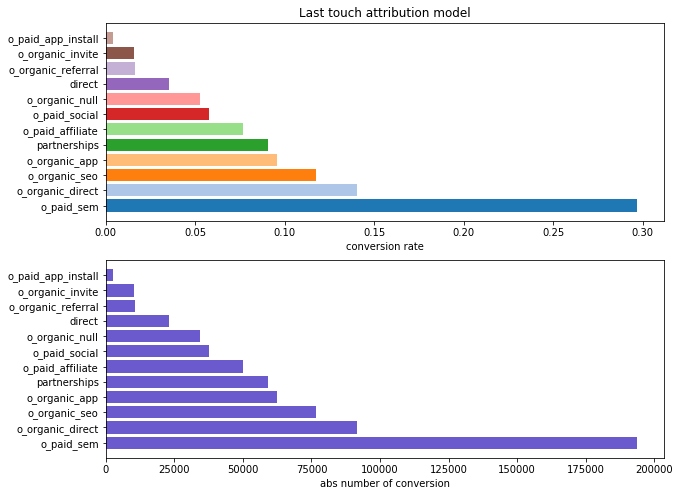

In [28]:
df_model = last_touch(basetable)

In [29]:
df_model

,conversion_abs,conversion_rate
o_paid_sem,193695,0.296947
o_organic_direct,91502,0.140278
o_organic_seo,76516,0.117304
o_organic_app,62339,0.095570
partnerships,59111,0.090621
o_paid_affiliate,50077,0.076771
o_paid_social,37541,0.057553
o_organic_null,34392,0.052725
direct,22967,0.035210
o_organic_referral,10858,0.016646


## 3.2 Monthly basic

In [37]:
basetable_m = basetable.assign(year_month = basetable.organization_created.dt.to_period('M'))

//anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


In [38]:
basetable_m.head()

,index,organization_uuid,organization_created,country_id,traffic_source_full,traffic_source,year_month
0,0,c86bbcc0-d0a3-11e7-8e84-d580513d4838,2017-11-23 23:12:31.884000+00:00,IT,ds_inbound_inbound,direct,2017-11
1,2,805f1370-b7ce-11e7-ba8a-4dd49cb4c1b2,2017-10-23 08:45:20.295000+00:00,IT,ds_inbound_inbound,direct,2017-10
2,4,28f9c6b0-d9b7-11e7-a769-14a76c0df6d1,2017-12-05 12:23:54.779000+00:00,IT,ds_inbound_inbound,direct,2017-12
3,5,a6496b10-58e3-11e8-8795-3443fe7b7b46,2018-05-16 08:32:20.545000+00:00,IT,ds_inbound_inbound,direct,2018-05
4,6,46024260-d443-11e7-b81c-ba318e3c1c62,2017-11-28 13:51:46.054000+00:00,IT,ds_inbound_inbound,direct,2017-11


In [39]:
def last_touch_m(df):
    df_group = pd.DataFrame(df.groupby('year_month')['traffic_source'].value_counts().unstack()).fillna(0)
    
    df_base = df_group.merge(pd.DataFrame(df_group.sum(axis = 1)),
                                      how = 'left',
                                      on = 'year_month')
    
    df_base.rename(columns = {0:'total_conversion'}, inplace = True)
    df_base.reset_index(inplace = True)
    
    base = pd.melt(df_base, id_vars = ['year_month','total_conversion'])
    base['conversion_rate'] = base['value']/base['total_conversion']
    
    return base.pivot(index = 'year_month', columns = 'variable', values = 'conversion_rate')

last_touch_m = last_touch_m(basetable_m)

In [40]:
last_touch_m

variable,direct,o_organic_app,o_organic_direct,o_organic_invite,o_organic_null,o_organic_referral,o_organic_seo,o_paid_affiliate,o_paid_app_install,o_paid_sem,o_paid_social,partnerships
year_month,,,,,,,,,,,,
2017-09,0.042809,0.015513,0.229676,0.040688,0.032558,0.016888,0.114524,0.054905,0.000471,0.271346,0.071361,0.109261
2017-10,0.047029,0.010375,0.252079,0.037112,0.019109,0.020177,0.116370,0.058204,0.000763,0.290335,0.067511,0.080937
2017-11,0.053424,0.014642,0.252540,0.038025,0.016788,0.020637,0.104954,0.060082,0.000663,0.278069,0.055854,0.104323
2017-12,0.034844,0.016443,0.266530,0.028885,0.015617,0.018836,0.093440,0.043196,0.000696,0.272664,0.087480,0.121368
2018-01,0.030225,0.019724,0.252720,0.027214,0.013362,0.015583,0.101667,0.050476,0.000489,0.304739,0.081718,0.102082
2018-02,0.031165,0.021769,0.249660,0.028741,0.014286,0.015051,0.111990,0.051148,0.000383,0.314753,0.066794,0.094260
2018-03,0.040396,0.027897,0.233755,0.029328,0.017243,0.015398,0.117273,0.073865,0.000753,0.291883,0.061215,0.090995
2018-04,0.030509,0.131840,0.121658,0.030735,0.042576,0.013463,0.117623,0.070408,0.002678,0.314289,0.029566,0.094656
2018-05,0.029049,0.167603,0.064251,0.026366,0.046435,0.014560,0.128108,0.067363,0.004758,0.312203,0.055414,0.083891


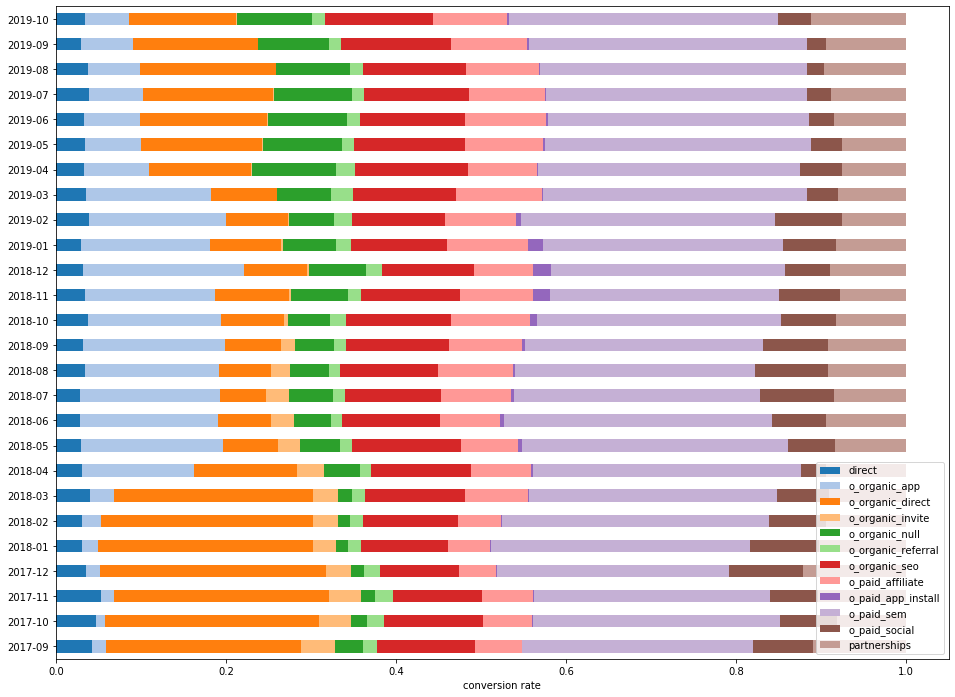

In [41]:
last_touch_m.plot.barh(stacked = True,
                         rot = 0,
                         figsize = (16,12),
                          color = sbn.color_palette('tab20'))
plt.xlabel('conversion rate')
plt.ylabel('')
plt.legend(loc = 'lower right')
plt.show()

## 3.3 Europe

In [42]:
country_list_euro = ['GB', 'FR', 'FI', 'NO', 'ES', 'NL', 'DE', 'DK', 'IT', 'SE']
basetable_europe = basetable[basetable['country_id'].isin(country_list_euro)]

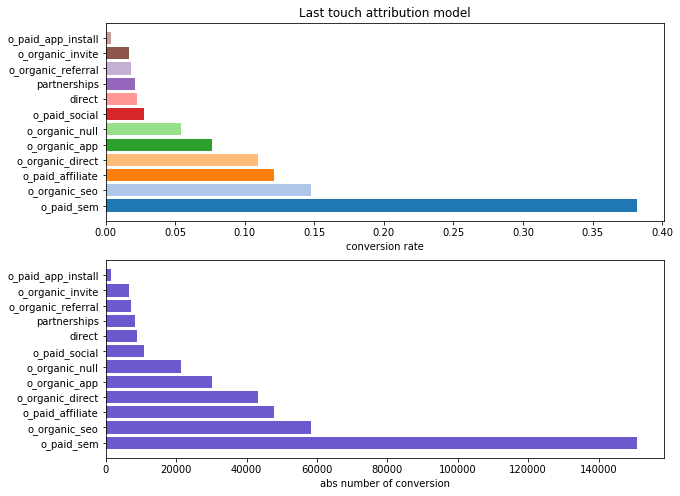

In [43]:
df_model_euro = last_touch(basetable_europe)

In [45]:
basetable_europe_m = basetable_europe.assign(year_month = basetable.organization_created.dt.to_period('M'))

In [47]:
def last_touch_m(df):
    df_group = pd.DataFrame(df.groupby('year_month')['traffic_source'].value_counts().unstack()).fillna(0)
    
    df_base = df_group.merge(pd.DataFrame(df_group.sum(axis = 1)),
                                      how = 'left',
                                      on = 'year_month')
    
    df_base.rename(columns = {0:'total_conversion'}, inplace = True)
    df_base.reset_index(inplace = True)
    
    base = pd.melt(df_base, id_vars = ['year_month','total_conversion'])
    base['conversion_rate'] = base['value']/base['total_conversion']
    
    return base.pivot(index = 'year_month', columns = 'variable', values = 'conversion_rate')

In [48]:
europe_m = last_touch_m(basetable_europe_m)

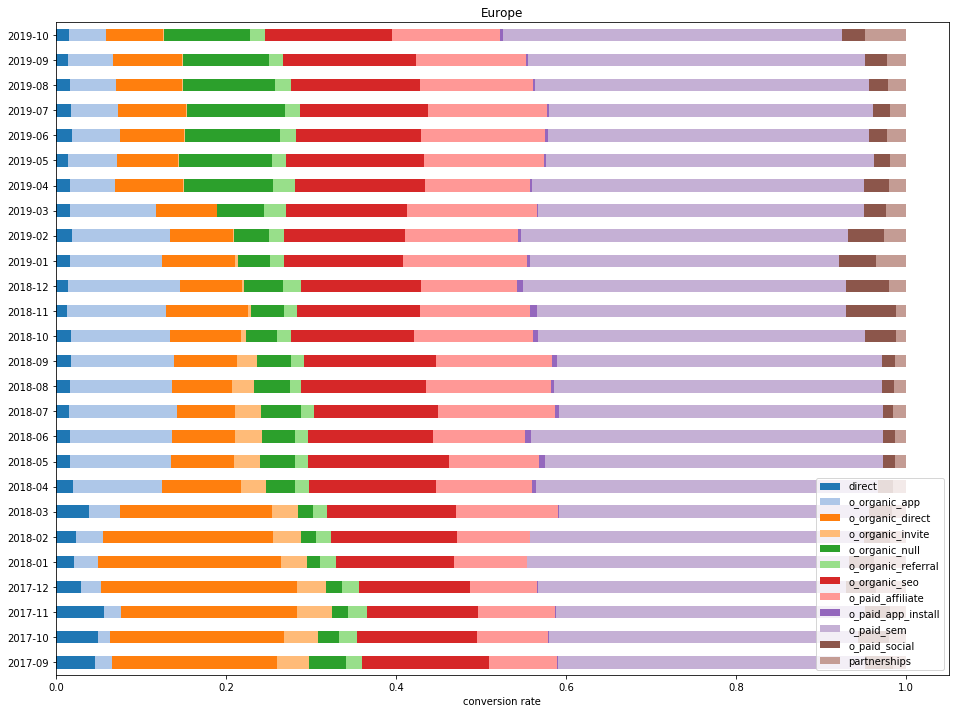

In [49]:
europe_m.plot.barh(stacked = True,
                         rot = 0,
                         figsize = (16,12),
                          color = sbn.color_palette('tab20'))
plt.xlabel('conversion rate')
plt.ylabel('')
plt.legend(loc = 'lower right')
plt.title('Europe')
plt.show()